# Tutorial 3: Inverse Kinematics

Content:

    1. Answers to Tutorial 2: Forward Kinematics
    2. Inverse Kinematics tasks

## Answers to Tutorial 2: Forward Kinematics

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from IPython.display import HTML

## Homogeneous Transformation Matrix

One key element in deriving the kinematics of a serial-chain manipulator is the homogeneous transformation matrix. We use this matrix to conveniently group the rotation and translation of a frame into a single matrix form: 
<br/> 
<br/> 
$$
T =
\left(\begin{array}{cc}
R & p \\
0_{1x3} & 1
\end{array}\right) 
=
\left(\begin{array}{cc}
r_{11} & r_{12} & r_{13} & x \\
r_{21} & r_{22} & r_{23} & y \\
r_{31} & r_{32} & r_{33} & z \\
0 & 0 & 0 & 1
\end{array}\right) 
$$

<br/>
For example, the homogeneous transform could be used when defining the the vector $^AP$ which describes a point relative to frame {A} using the known pose or transform between frames {A} to {B} and knowing the vector $^BP$.

<img src="images/frames.png" style="width: 450px;">

Without our homogeneous transformation matrix, this relationship would be described as:
<br/>
<br/>
<center>$^AP = {^A}R_B {^BP} + {^A}P_{BORG}$ </center>

But using the transformation matrix this relationship can be concisely written as:
<br/> 
<br/> 
<center>$$
\left(\begin{array}{c}
^AP \\
1
\end{array}\right) 
 = {^A}T_B 
\left(\begin{array}{c}
{^BP} \\
1
\end{array}\right) 
$$ </center>
<br/>
Where $^AP$ and $^BP$ are two vectors with positions known relative to frames {A} and {B} respectively.
<br/> 
<br/> 

## 3-Link Planar Manipulator
Below is the 3-link planar manipulator whose forward kinematics we will be implementing. The lengths of links 1, 2 and 3 are $L_1, L_2$ and $L_3$. The rotation about each of the three joints are ${\theta}_1, {\theta}_2$ and ${\theta}_3$. The **link 0** is the fixed base, e.g. the ground. The **end-effector** is the manipulator attached at the end of the robot which is the black gripper, see the diagrams below.

<table>
    <tr>
        <td><img src="images/3-link-angles.png" style="width: 300px;"> </td>
        <td><img src="images/3-link-frames.png" style="width: 280px;"> </td>
    </tr>
    <tr>
        <td style="text-align:center">Diagram of the links and joints</td>
        <td style="text-align:center">Diagram of the frames</td>
    </tr>
</table>

### Tasks:
1. Calculate the homogeneous transform matrice 
    * From frame {0} to {1} (no translation, rotation only)
    * From frame {1} to {2}
    * From frame {2} to {3}
2. Then, use the homogeneous transform matrice from (1), calculate the homogeneous transform matrix from the base (frame {0}) to the end-effector.
3. Ultimately, use the matrice from (1) and (2), implement a function that determines the x-y coordinate of each frame & the end-effector under the fixed frame {0}.

The tool you may find useful: 

    1. The 2-D homogeneous transform matrix is in the form of:
    
$$
T =
\left(\begin{array}{cc}
R & p \\
0_{1x2} & 1
\end{array}\right) 
=
\left(\begin{array}{cc}
r_{11} & r_{12}  & x \\
r_{21} & r_{22}  & y \\
0 & 0 & 1
\end{array}\right) 
$$

    2. The 2D rotation matrix $R$ parametrised with rotation angle $\theta$ is defined as:

$$
R
=
\left(\begin{array}{cc}
cos(\theta) & -sin(\theta) \\
sin(\theta) & cos(\theta) \\
\end{array}\right) 
$$


### Forward Kinematics (Answers)

In [45]:
class ThreeLinkArm:
    
    def __init__(self):
        # Set parameters for the 3-link planar arm
        
        self.theta1 = np.deg2rad(0)
        self.theta2 = np.deg2rad(90)
        self.theta3 = np.deg2rad(90)
        self.l1 = 5
        self.l2 = 3
        self.l3 = 2

    def forwardKinematics(self, theta1, theta2, theta3):
        # Define the homogeneous transformation matrices for the 3-link planar arm
        
        self.theta1 = theta1
        self.theta2 = theta2
        self.theta3 = theta3

        self.t01 = np.matrix([
                        [np.cos(self.theta1), -np.sin(self.theta1), 0],
                        [np.sin(self.theta1), np.cos(self.theta1), 0],
                        [0, 0, 1]
                    ])
        
        # Implement the transformation matrix from frame {1} to frame {2}
        self.t12 = np.matrix([
            [np.cos(self.theta2), -np.sin(self.theta2), self.l1],
            [np.sin(self.theta2), np.cos(self.theta2), 0],
            [0, 0, 1]
        ])


        self.t23 = np.matrix([[np.cos(self.theta3), -np.sin(self.theta3), self.l2],
                        [np.sin(self.theta3), np.cos(self.theta3), 0],
                        [0, 0, 1]])
        
        # Implement the transformation matrix from frame {3} to the tip of the end-effector
        self.t3end = np.matrix([
            [1, 0, self.l3],
            [0, 1, 0],
            [0, 0, 1]
        ])
        
        self.t0end = self.t01*self.t12*self.t23*self.t3end
        
        return self.t0end
    
    def findJointPos(self): 
        # Find the x,y position of each joint and end effector so it can be plotted
        
        # Find the transformation matrices for joint 2 and joint 3
        self.t02 = self.t01*self.t12
        self.t03 = self.t01*self.t12*self.t23
        
        # Find the x, y coordinates for joints 2 and 3. Put them in a list j2 = [x,y]
        j2 = [ self.t02[0, 2], self.t02[1, 2] ]
        j3 = [ self.t03[0, 2], self.t03[1, 2] ]
        
        endeff = np.array([self.t0end[0,2],self.t0end[1,2]])
        
        return j2,j3,endeff
        

def plotArm(jnt2pos, jnt3pos, endEffectPos, target=None, step=None):
    # set up figure
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111, autoscale_on=False,
                         xlim=(-10, 10), ylim=(-10, 10))
    ax.grid()
    
    if target is not None:
        target = np.array(target)
        if step is not None:
            step = np.vstack([[endEffectPos[0], endEffectPos[1]],  step,  target])
            step = np.array(step)
            plt.plot(step[:, 0],step[:, 1],'ob-')
        plt.plot(target[0],target[1],'or')
        
    line, = ax.plot([], [], 'o-', lw=4, mew=5)
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

    line.set_data([], [])
    time_text.set_text('')
    x = np.array([0, jnt2pos[0], jnt3pos[0], endEffectPos[0]])
    y = np.array([0, jnt2pos[1], jnt3pos[1], endEffectPos[1]])
    line.set_data((x,y))
    
    plt.show()
    

Homogeneous matrix from base to end effector: 
[[ 0.70710678 -0.70710678  4.94974747]
 [ 0.70710678  0.70710678  7.94974747]
 [ 0.          0.          1.        ]]
Joint 3 Coordinates: [3.535533905932738, 6.535533905932738]
End effector Coordinates: [4.94974747 7.94974747]


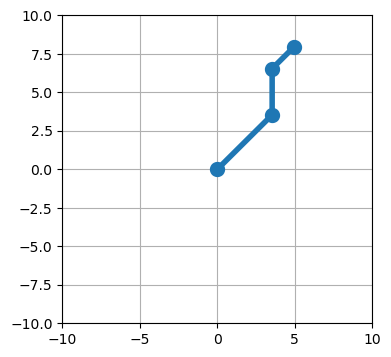

In [46]:
arm = ThreeLinkArm()

# Do forward kinematics for a set angle on each joint
T = arm.forwardKinematics(np.deg2rad(45),np.deg2rad(45),np.deg2rad(-45))

# Find the x,y coordinates of joints 2, 3 and end effector so they can be plotted
joint2pos, joint3pos, endEffectorPos = arm.findJointPos()

# Print joint + end effector positions
print("Homogeneous matrix from base to end effector: \n" + str(T))
print("Joint 3 Coordinates: " + str(joint3pos))
print("End effector Coordinates: " + str(endEffectorPos))

# Plot the pose of the arm
plotArm(joint2pos, joint3pos, endEffectorPos)

---

# Tutorial 3: Inverse Kinematics

Welcome to Tutorial 3, where we will be looking at the Inverse Kinematics (IK). Again,
* Forward kinematics: Finding the position and orientation of the end-effector relative to the base given the angles of all the joints.
* Inverse kinematics: Finding the values of the joint angles given the position and orientation of the end-effector relative to the base. 

In this section we will be looking at the Jacobian inverse technique, a method used to solve inverse kinematics. As we saw in the previous section the forward kinematics are described with a function that maps joint angles to end-effector pose:
<br/> 
<br/> 
$$ \mathbf{y} = \phi(\boldsymbol{\theta})$$
<br/> 

For the Inverse kinematics we would like to have a function that maps the end-effector pose to joint angles:
<br/> 
<br/> 
$$ \boldsymbol{\theta} = \psi(\mathbf{y})$$
<br/> 
However, as $\phi(\cdot)$ is nonlinear, obtaining $\psi$ is not possible. Therefore, we differentiate the forwards kinematics function:
<br/> 
<br/> 
$$ \frac{\partial \mathbf{y}}{\partial t} = \frac{\partial \phi(\boldsymbol{\theta})}{{\partial t}}$$
<br/> 
<br/> 
$$ \frac{\partial \mathbf{y}}{\partial t} = \frac{\partial \phi(\boldsymbol{\theta})}{{\partial \boldsymbol{\theta}}} \frac{\partial \boldsymbol{\theta}}{\partial t}$$
<br/> 
<br/> 
$$ \dot{\mathbf{y}} = \frac{\partial \phi(\boldsymbol{\theta})}{{\partial \boldsymbol{\theta}}} \dot{\boldsymbol{\theta}}$$
<br/> 
Compactly written as:
<br/> 
<br/> 
$$ \dot{\mathbf{y}} = J \dot{\boldsymbol{\theta}}$$
<br/> 

Where $\dot{y}$ is the change in end-effector position, $\dot{\theta}$ is the change in joint angles and $J$ is the derivative of the forward kinematics function called the Jacobian. The Jacobian matrix represents the relationship between the position of the end-effector and rotation of each joint: 

<br/> 
$$ J = \frac{\partial \phi(\boldsymbol{\theta})} {{\partial \boldsymbol{\theta}}} $$
<br/> 
<br/> 
$$
J =
\left(
\begin{array}{cc}
\frac{\partial \phi_x(\boldsymbol{\theta})} {{\partial \boldsymbol{\theta_1}}} & \frac{\partial \phi_x(\boldsymbol{\theta})}{{\partial \boldsymbol{\theta_2}}} & \frac{\partial \phi_x(\boldsymbol{\theta})}{{\partial \boldsymbol{\theta_3}}}\\
\frac{\partial \phi_y(\boldsymbol{\theta})} {{\partial \boldsymbol{\theta_1}}} & \frac{\partial \phi_y(\boldsymbol{\theta})}{{\partial \boldsymbol{\theta_2}}} & \frac{\partial \phi_y(\boldsymbol{\theta})}{{\partial \boldsymbol{\theta_3}}}\\
\frac{\partial \phi_z(\boldsymbol{\theta})} {{\partial \boldsymbol{\theta_1}}} & \frac{\partial \phi_z(\boldsymbol{\theta})}{{\partial \boldsymbol{\theta_2}}} & \frac{\partial \phi_z(\boldsymbol{\theta})}{{\partial \boldsymbol{\theta_3}}}\\
\end{array}
\right) 
$$
<br/> 

#### Once we have the Jacobian, we can obtain the differential inverse kinematics:
$$ \boldsymbol{\dot{\theta}} = J^{-1} \dot{\mathbf{y}} $$
<br/> 
In most cases, the Jacobian is not symmetric, therefore the inverse of the Jacobian is not defined. So we use the **pseudo-inverse** of the Jacobian:

<br/>
$$ \dot{\boldsymbol{\theta}} = J^{\dagger} \dot{\mathbf{y}} $$
<br/>
Which tells us how changing joint angles $\dot{\boldsymbol{\theta}}$ affects the change in end-effector position $\dot{\mathbf{y}}$. 


### Finding the Jacobian:
<br/> 
<br/> 
<img src="images/Img-Kinematics.png" style="width: 280px;"> 
<br/> 
Where $a_i$ is the rotation axis $p_i$ is the position of the *i*th joint. 

#### Geometric Jacobian:
<br/> 
<br/> 
<img src="images/Img-Kinematics_Jacob.png" style="width: 580px;"> 


In [47]:
# compute the geometric Jacobian  
def geomJacobian(jnt2pos, jnt3pos, endEffPos):
    
    ai = np.array([0,0,1])
    endEffPos3d = np.pad(endEffPos,(0, 1), 'constant') #append a 0 on z
    col0 = endEffPos3d
    col1 = endEffPos3d - np.array(jnt2pos + [0])
    col2 = endEffPos3d - np.array(jnt3pos + [0])
    J = np.array([np.cross(ai,col0), np.cross(ai,col1), np.cross(ai,col2)]).T 
    return J

# gif animation plotter
def plotArm2(jnt2pos, jnt3pos, endEffectPos, target=np.array([0,0]), step=np.array([0,0]), fig=None, camera=None):
    # set up figure
    ax = fig.add_subplot(111, autoscale_on=False,
                         xlim=(-10, 10), ylim=(-10, 10))
    ax.grid()
    line, = ax.plot([], [], 'o-', lw=4, mew=5, color='lightblue')
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

    line.set_data([], [])
    time_text.set_text('')
    x = np.array([0,
                   jnt2pos[0],
                   jnt3pos[0],
                   endEffectPos[0]])
    y = np.array([0,
                   jnt2pos[1],
                   jnt3pos[1],
                   endEffectPos[1]])
    line.set_data((x,y))
    plt.plot(target[0],target[1],'or')
    plt.plot(step[0],step[1],'og')

    camera.snap()

### Jacobian Iterative Inverse Kinematics Algorithm: 
<img src="images/Img-Kinematics_algorithm.png" style="width: 700px;"> 
<br/>
The Jacobian inverse technique then works by iteratively computing a change in joint angles $\delta\boldsymbol{\theta}$ to reduce the error between the initial and target position. 
Let's break down the task into smaller pieces:

#### First, let's define the starting position and the target position of the end-effector

In [48]:
# Setup our new manipulator
IK_arm = ThreeLinkArm()

In [49]:
# define the initial configuration of the manipulator (you are welcomed to try other values)
initTheta = [np.deg2rad(45),np.deg2rad(45),np.deg2rad(-45)]

# Define the target postion of the end-effector
EF_target_pos = np.array([-3,7.5])

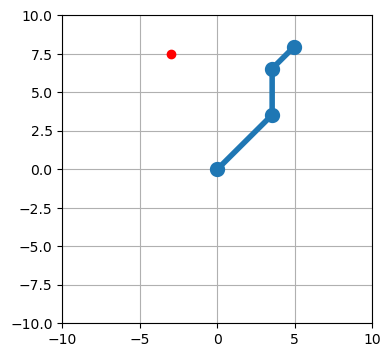

In [50]:
# Initialise the arm with the initial values
T = IK_arm.forwardKinematics(*initTheta)

# Plot the pose of the arm
plotArm(*IK_arm.findJointPos(), target=EF_target_pos)

In [86]:
# Get the initial end-effector position 
init_joint2pos, init_joint3pos, EF_init_pos = IK_arm.findJointPos()

#### Now, let's interpolate the end-effector positions given the initial and final (target) end-effector positions

In [87]:
# Define the interpolation steps
IK_steps = 4

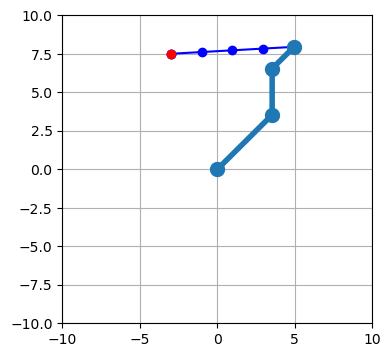

In [88]:
# Write some code to interpolate the intermediate positions given the initial 
# and final E-F positions.
##
step_positions = []

### START CODE HERE
step_positions = np.linspace(start=EF_target_pos,stop=EF_init_pos, num=IK_steps, endpoint=False)[::-1]
### END CODE HERE

assert(len(step_positions) == IK_steps), \
    f"You should have divided the total dy into {IK_steps} smaller intermediate steps"

plotArm(*IK_arm.findJointPos(), target=EF_target_pos, step=step_positions)

#### To find the Jacobian matrix, we only need the current configuration of the robot, please use the "geomJacobian()" function provided above to get Jacobian matrice

In [89]:
### START CODE HERE
Jacobian_matrix = geomJacobian(init_joint2pos, init_joint3pos, EF_init_pos)
### END CODE HERE

# Let's see if you have got the correct answer.
if (np.all(Jacobian_matrix - np.array([[-7.94974747, -4.41421356, -1.41421356],
       [ 4.94974747,  1.41421356,  1.41421356],
       [ 0.        ,  0.        ,  0.        ]]) < 0.00001)):
    print("Great! That's it!")
else:
    raise Exception("Maybe have another look at the Jacobian matrix?")

Great! That's it!


### Let's get on the real tasks:
* Fill in the missing line of the algorithm that computes the $\delta\boldsymbol{\theta}$ given $\delta \mathbf{y}$
* Change the number of steps and explain the behaviour of the algorithm for small number of steps $\approx 4$

In [114]:
# set the current E-F position for the IK loop
joint2pos, joint3pos, endEffectorPos = init_joint2pos, init_joint3pos, EF_init_pos
# set the initial robot configuration
newTheta = initTheta

# Set up the animation generator
fig = plt.figure(figsize=(4,4))
camera = Camera(fig)
print (step_positions)


for i in range(IK_steps):
    # obtain the Jacobian, use the current joint configurations and E-F position
    ### START CODE HERE
#     print ("Joint 2 pos = ", joint2pos)
#     print ("Joint 3 pos = ", joint3pos)
#     print ("EFF pos = ", endEffectorPos)

    J = geomJacobian(joint2pos, joint3pos, endEffectorPos) # fix me!
    
    ### END CODE HERE
    
    # compute the dy steps
    newgoal = step_positions[i, :]
    deltaStep = newgoal - np.abs(endEffectorPos)
    
    # define the dy
    subtarget = np.array([deltaStep[0], deltaStep[1], 0]) 

    # compute dq from dy and pseudo-Jacobian
    ### START CODE HERE

    radTheta = np.matmul(np.linalg.pinv(J), subtarget) # fix me!
    print("Joints: ", *list(map(np.rad2deg, radTheta)))
    ### END CODE HERE
    
    # update the robot configuration
    ### START CODE HERE
    newTheta =  radTheta
#     print(newTheta)
    ### END CODE HERE
    

    # ----------- Do forward kinematics to plot the arm ---------------
    # Do forward kinematics for a set angle on each joint
    T = arm.forwardKinematics(newTheta[0],newTheta[1],newTheta[2])

    # Find the x,y coordinates of joints 2, 3 and end effector so they can be plotted
    joint2pos, joint3pos, endEffectorPos = arm.findJointPos()

    # Plot the pose of the arm
    plotArm2(joint2pos, joint3pos, endEffectorPos, EF_target_pos, newgoal, fig, camera)
plt.close()
animation = camera.animate()
animation.save('animated_IK.gif', writer = 'imagemagick')

#random code to make sure the gif is reloaded (jupyter bug)
import random
__counter__ = random.randint(0,2e9)

# show the animation
from IPython.display import HTML, display
display(HTML('<img src="animated_IK.gif?%d">'% __counter__))
# Ignore the warning message

#Joints:  -8.672143655745831 48.776777814858576 -22.979568588241786

[[ 2.9623106   7.8373106 ]
 [ 0.97487373  7.72487373]
 [-1.01256313  7.61243687]
 [-3.          7.5       ]]
-8.672143655745831 48.776777814858576 -22.979568588241786
-73.77376151210872 233.03848966860926 18.89918114359898
-67.98620618442776 3.327770752995044 -4.976341591545553
-93.48892519105819 314.9461177330712 -520.0151280759197


/afs/inf.ed.ac.uk/user/s19/s1912633/.conda/envs/ARO_Tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


#### That's it, well done!